# AM207 Fall '19 Final Project

###  A study on _Variational Inference with Normalizing Flows_
---

#### Brian Chu
#### Cooper Lorsung
#### Jovin Leong



---

# Abstract

In Bayesian statistics, Variational Inference (VI) is an important method with myriad applications that enables us to approximate difficult posteriors through optimization. The method involves proposing a simpler distributional family that resembles our target distribution which we can subsequently sample from (Wainwright and Jordan, 2008). A key assumption that is often made in VI is the mean-field assumption in VI approximation—however, as we will shortly see, this is a restrictive and often inappropriate assumption to make.

Our project examines Mohamed and Rezende's 2015 paper  _Variational Inference with Normalizing Flows_ where the authors seek to resolve this dependence on mean-field approximations through the use of normalizing flows in VI. We, therefore, endeavour to explain and implement key aspects of the proposed approach and, in doing so, we hope  to more clearly express the intuition and reasoning behind the approach and its limitations.

---

# Background
As mentioned above, VI allows for posterior inference of large and complex problems through the use of a distribution $q$ that is relatively easy for us to sample from, where $q$ comes from a family of distributions $Q$ (Hoffman et al., 2013). A frequently used family of approximations is the mean-field variational family, where the latent variables are assumed to be determined by a distinct factor in the variational density and are assumed to be mutually independent (Blei et al., 2018).

<br>

$$q(x) = \prod_{i=1}^{m}q_i(z_i)$$

**<center>Member of the mean-field variational family</center>**

<br>

The mean-field assumption of mutual independence is useful to us in VI as it enables us to, in the optimization of the Evidence Lower Bound (ELBO) for a proposal distribution $q(\phi)$, assume that the joint $q(\phi)$ factorizes completely over each dimension of $\phi$. The assumption enables us to easily capture the marginal density of latent variables and rewrite the expectation in the ELBO over all $\phi_i$s jointly as the iterated expectation.

However, this assumption is problematic because it fails to capture any correlation between our variables. The mean-field assumption, by construction, assumes away any correlation between variables. In cases where our posterior density exhibits correlation, although our variational approximation with the mean-field assumption might have the same mean as our posterior density, the covariance structure will (as a consequence of our assumption) be decoupled (Blei et al., 2018).

Another consequence of using mean-field variational approximation is that the Kullback-Leibler divergence (as illustrated below), that is used in our optimization, results in the underrepresentation of the posterior variance.

<br>

$$D_{KL} [q(z)||p(z | x)] = E[log q(z)] − E[log p(z | x)]$$
**<center>Kullback-Leibler divergence</center>**

<br>

    Insert analytical proof of this underrepresentation
  
As such, Mohamed and Rezende's 2015 paper proposes an alternative approach to performing VI: VI through the use of normalizing flows.

Normalizing flows refer to an approach where we take a relatively simple base distribution and perform a series of invertible mappings such that, at the end of these transformations, we arrive at an approximation of our posterior. Mohamed and Rezende propose the use of normalizing flows as an alternative approach to flexibly approximating posteriors through VI. Their approach enables us to perform VI without having to make the mean-field assumption.

To illustrate this, we will produce pedagogical examples to illustrate the limitations of using mean-field variational families in VI and how normalizing flows can be used to approximate a posterior distribution. We also perform a rudimentary implementation of Mohamed and Rezende's approach.

In subsequent sections, we further explore the approach of using VI with normalizing flows in greater detail and examine the boundaries of this approach through a more sophisticated implementation. 

Finally, we conclude our study with an evaluation and discussion of Mohamed and Rezende's approach by making comparisons to alternative approaches.



---

# Pedagogical Example: Variational Inference with Mean Field Assumption

In our example below, we implement Black Box Variational Inference (BBVI) for a posterior approximation to illustrate an instance where VI with the mean-field assumption breaks down.

<br>
We begin by generating data that follows an anisotropic Gaussian and we subsequently use our BBVI implementation to approximate our posterior distribution. Following that, we calculate our analytical mean and variances in order to visualize the posterior distribution which we overlay with our BBVI approximation for the purposes of evaluation.


In [0]:
%matplotlib inline
import numpy
import tensorflow as tf
from autograd import numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd
import pandas as pd
from matplotlib import pyplot as plt
from autograd.scipy.stats import multivariate_normal, norm
from matplotlib.gridspec import GridSpec
import itertools
from scipy.stats import multivariate_normal as mvn

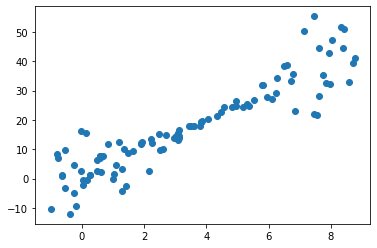

In [0]:
def f(x):
    return np.random.normal(5, 1)*x + np.random.normal(0, 2*np.abs(x-4))

x_pos = np.random.uniform(-1, 9, 100)
y_pos = f(x_pos)
fig, ax = plt.subplots()
ax.scatter(x_pos, y_pos)
plt.show()

We assume that the outcome $y$ can be modeled by the following process:


\begin{aligned}
y &= f(x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.5)\\
f(x) &= w_1x + w_0 \\
w_0 &\sim \mathcal{N}(0, 1)\\
w_1 &\sim \mathcal{N}(0, 0.5)
\end{aligned}



In this model, we assume the same likelihood as before, but we also include the following priors for $w_0$ and $w_1$: 

\begin{aligned}
&p(w_0) = \mathcal{N}(0, 1) \\
&p(w_1) = \mathcal{N}(0, 0.5)
\end{aligned}

In [0]:
x = np.copy(x_pos)
y = np.copy(y_pos)

sig_inv = np.array([[2,0],[0,1]]) # Inverse coviariance of w0, w1

# Create X, y is already in a suitable form
X = np.zeros((len(x),2))
X[:,0] = 1
X[:,1] = x

# Calculate mean and variance according to formula derived above
cov = np.linalg.inv(2*np.dot(X.T, X) + sig_inv)
mean = 2*np.dot(np.dot(y.T, X), cov)

factor = 40
w0_lims = sorted([mean[0] + factor*cov[0][0]*mean[0], mean[0] - factor*cov[0][0]*mean[0]])
w1_lims = sorted([mean[1] + factor*cov[1][1]*mean[1], mean[1] - factor*cov[1][1]*mean[1]])

# Grid of points for heatmap, based on confidence intervals in part 1
gridsize = 50
#w0 = np.linspace(8.6, 9.1, gridsize)
#w1 = np.linspace(5.16, 5.3, gridsize)
w0 = np.linspace(*w0_lims, gridsize)
w1 = np.linspace(*w1_lims, gridsize)
grid = [el for el in itertools.product(w0, w1)]

# Create multivariate gaussian and sample on a grid
print("ANALYTICAL MEAN: {}".format(mean))
print("\nANALYTICAL COVARAINCE: {}".format(cov))
multi_norm = mvn(mean, cov)
vals = multi_norm.pdf(grid)

# Calculate probabilities and marginals
W0, W1 = np.meshgrid(w0, w1)
vals = np.reshape(vals, (50,50))
w0_marginals = np.sum(vals, axis=0)
w1_marginals = np.sum(vals, axis=1)
normalization = np.sum(vals)
ticks = [0, 9, 19, 29, 39, 49]

ANALYTICAL MEAN: [1.51795512 4.70364431]

ANALYTICAL COVARAINCE: [[ 0.01148519 -0.00193385]
 [-0.00193385  0.0005723 ]]


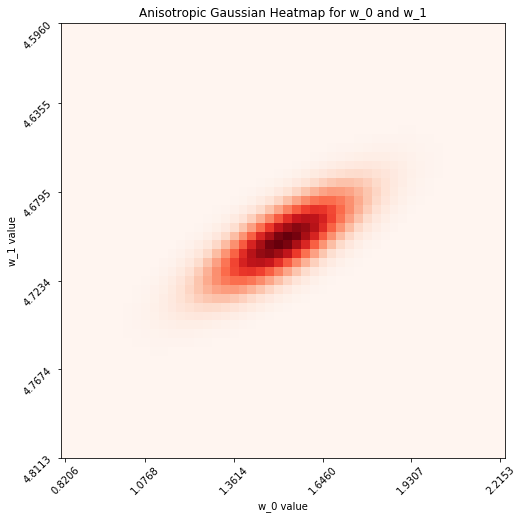

In [0]:
fig, ax = plt.subplots(figsize=(8,8))

ax.imshow(vals, cmap="Reds")
ax.set(xticks=ticks, xlabel='w_0 value', yticks=ticks, ylabel='w_1 value',
       title='Anisotropic Gaussian Heatmap for w_0 and w_1')
ax.set_xticklabels(["{0:.4f}".format(v) for v in W0[0][ticks]], rotation=45)
ax.set_yticklabels(["{0:.4f}".format(v) for v in W1[:,0][ticks]], rotation=45)
plt.show()

In [0]:
def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params
    
def variational_inference(sigmaw, sigmay, y_train, x_train, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = 2
    variational_dim = D
    #sigmay_inv = np.linalg.inv(sigmay)
    #sigmay_det = np.linalg.det(sigmay)

    
    def log_prior(w):
        w = w[0]
        constant_w = -0.5*(np.log(2*np.pi) + np.log(sigmaw[0]))
        constant_w += -0.5*(np.log(2*np.pi) + np.log(sigmaw[1]))
        
        exponential_w = -0.5 * w[0]**2/sigmaw[0]**2
        exponential_w += -0.5 * w[1]**2/sigmaw[1]**2
        #return np.log(norm.pdf(w[0], 0, sigmaw[0])) + np.log(norm.pdf(w[1], 0, sigmaw[1]))
        return constant_w + exponential_w
        

    def log_likelihood(w):
        minibatches = len(w)
        w = w[0]
        if(minibatches==1):
            w = [w.T]
        w = np.array(w)
        mv_mean = np.dot(X, w.T)
        #print(mv_mean.shape)
        #return np.log(multivariate_normal.pdf(y, mean=mv_mean, cov=sigmay*np.eye(len(y))))
    
        constant = -0.5 * (np.log(2 * np.pi) + np.log(sigmay))*minibatches
        exponential = sum([-0.5*1/(sigmay) * np.dot((y - np.dot(X, w[i])).T, (y-np.dot(X,w[i]))) for i in range(minibatches)])
        return constant + exponential
    
    log_density = lambda w, t: log_likelihood(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if(verbose and t!=0):
            if  t % 1000 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    #initialize variational parameters
    init_mean = np.copy(mean)
    #init_mean = 3*np.ones(D)
    init_log_std = np.log([0.5*cov[0][0], 0.5*cov[1][1]])
    #init_log_std = -10*np.ones(D)
    
    init_var_params = np.concatenate([init_mean, init_log_std])
    print("INIT VAR PARAMS: {}".format(init_var_params))
    
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params 


In [0]:
sigmaw = np.diag([1, 2])
sigmaw = np.array([1, 2])
sigmay = 0.5
params = variational_inference(sigmaw, sigmay, y, x, 1, 20000, 1e-3, True)

Optimizing variational parameters...
INIT VAR PARAMS: [ 1.51795512  4.70364431 -5.15984443 -8.15899834]
Iteration 1000 lower bound -3628.78200281849; gradient mag: 2.9502504119592423
Iteration 2000 lower bound -3626.890308854707; gradient mag: 13.256133417538384
Iteration 3000 lower bound -3625.402105991817; gradient mag: 21.697468462452505
Iteration 4000 lower bound -3625.1351285809315; gradient mag: 130.6572293802208
Iteration 5000 lower bound -3624.733074449817; gradient mag: 133.9640245200738
Iteration 6000 lower bound -3624.9746127050007; gradient mag: 40.22992177240832
Iteration 7000 lower bound -3625.5872705381635; gradient mag: 25.4304000292309
Iteration 8000 lower bound -3624.298532299609; gradient mag: 101.24903454910088
Iteration 9000 lower bound -3627.1757043793214; gradient mag: 53.6762162992778
Iteration 10000 lower bound -3624.4063714310532; gradient mag: 52.859896763257396
Iteration 11000 lower bound -3624.89784107248; gradient mag: 29.20753172477522
Iteration 12000 low

In [0]:
variational_mean = params[:2]
variational_cov = np.exp(params[2:])**2
print("ANALYTICAL MEAN:\n{}\n\nANALYTICAL COVARIANCE:\n{}".format(mean, cov))
print("\nVARIATIONAL MEAN:\n{}\n\nVARIATIONAL VARIANCE:\n{}".format(variational_mean, variational_cov))

x_grid, y_grid = numpy.mgrid[w0_lims[0]:w0_lims[1]:.001, w1_lims[0]:w1_lims[1]:.001]
pos = numpy.dstack((x_grid, y_grid))
z_p = multivariate_normal.pdf(pos, mean, cov)
z_q = multivariate_normal.pdf(pos, variational_mean, variational_cov)

ANALYTICAL MEAN:
[1.51795512 4.70364431]

ANALYTICAL COVARIANCE:
[[ 0.01148519 -0.00193385]
 [-0.00193385  0.0005723 ]]

VARIATIONAL MEAN:
[1.52931105 4.70314882]

VARIATIONAL VARIANCE:
[0.00501884 0.00023687]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'label'
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  
No handles with labels found to put in legend.


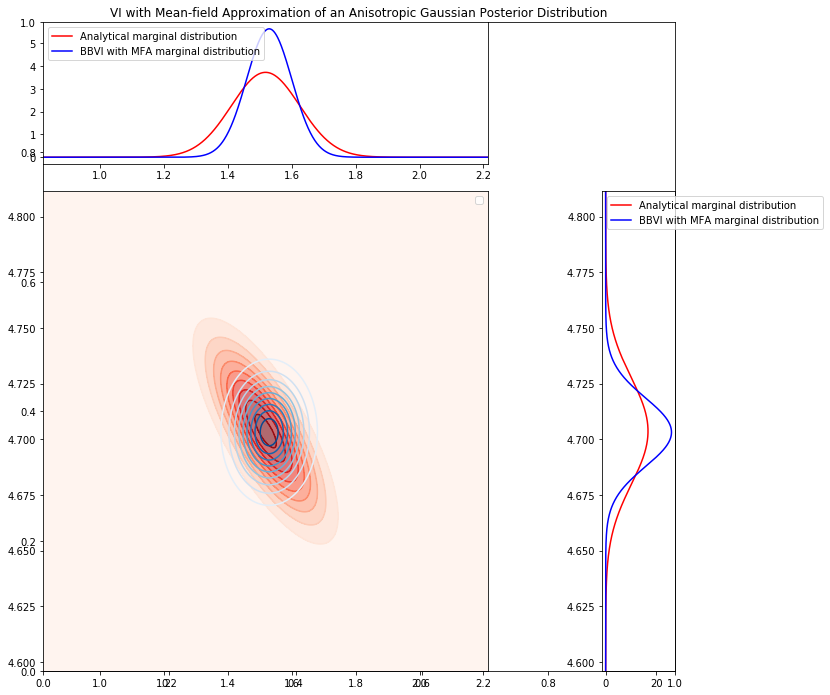

In [0]:
# Plotting analytical vs MFA posterior
fig = plt.figure(figsize=(10,10))
plt.title("VI with Mean-field Approximation of an Anisotropic Gaussian Posterior Distribution")
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4, 0:3])
ax_joint.set(xlim=w0_lims, ylim=w1_lims)
ax_joint.contour(x_grid, y_grid, z_p, levels=10, cmap='Reds', label="Analytical target posterior")
ax_joint.contourf(x_grid, y_grid, z_p, levels=10, cmap='Reds', alpha=0.6,label="BBVI with MFA approximate posterior")
ax_joint.contour(x_grid, y_grid, z_q, levels=10, cmap='Blues', label="BBVI with MFA approximate posterior")
ax_joint.legend()

ax_marg_x = fig.add_subplot(gs[0, 0:3])
x_marginal = np.linspace(*w0_lims, 1000)
ax_marg_x.set(xlim=w0_lims)
ax_marg_x.plot(x_marginal, norm.pdf(x_marginal, mean[0], np.sqrt(cov[0][0])), color='r', label="Analytical marginal distribution")
ax_marg_x.plot(x_marginal, norm.pdf(x_marginal, variational_mean[0], np.sqrt(variational_cov[0])), color='b', label="BBVI with MFA marginal distribution")
ax_marg_x.legend()

ax_marg_y = fig.add_subplot(gs[1:4, 3])
y_marginal = np.linspace(*w1_lims, 1000)
ax_marg_y.set(ylim=w1_lims)
ax_marg_y.plot(norm.pdf(y_marginal, mean[1], np.sqrt(cov[1][1])), y_marginal, color='r', label="Analytical marginal distribution")
ax_marg_y.plot(norm.pdf(y_marginal, variational_mean[1], np.sqrt(variational_cov[1])), y_marginal, color='b', label="BBVI with MFA marginal distribution")
ax_marg_y.legend()

plt.tight_layout()
plt.show()

As can be observed from the above plot, BBVI does a poor job of approximating an anisotropic Gaussian

From the heatmaps, we see that although the BBVI is able to have the same mean as the original density, the approximation fails to capture the covariance structure of the posterior.

From the marginal distribution plots of both $w_0$ and $w_1$, the BBVI approximation places more mass about the mean and does not capture the tailedness of our posterior distribution.

We can see from the contour plot that BBVI with mean-field approximation is unable to capture the “ovalness” of our actual distribution. BBVI approximates our distribution using an isotropic normal distribution, which has no covariance between variables. However, the actual distribution has non-zero off-diagonal entries in the covariance matrix. When we look closer at the marginal distributions of w0 and w1, we can see that both BBVI and the actual distribution have normal distributions for the two variables. However, one of the goals of using a distribution is to be able to estimate uncertainty and not rely solely on a point estimate. The marginal distribution of BBVI has a much lower standard deviation compared to the actual distribution. This means that when we try to estimate our uncertainty using its approximation, we will be severely overconfident in our point estimate.

We now continue into the second part of our pedagogical example where we perform a rudimentary implementation of Mohamed and Rezende's proposed approach using normalizing flows.

---

# Pedagogical Example: Normalizing flows

Our pedagogical example here illustrates how normalizing flows might be used for variational inference of a posterior distribution; as such, for the purposes of this illustration, we perform a rudimentary implementation involving a single fixed flow that does not require training our flow on our data.

<br>

Our flow, here, consists of an analytically derived function that takes in the analytical covariance of our posterior and performs affine transformations on our samples obtained from our proposed distribution (a standard Gaussian distribution); this process is essentially akin to implementing a planar flow analytically.

<br>

We first define our single fixed flow as a function ```find_L``` which takes in as input the analytical covariance matrix and outputs a transformation matrix that is essentially our 'flow function'.

In [0]:
# Normalizing flow
def find_L(cov):
    sig1 = cov[0][0]
    sig2 = cov[0][1]
    sig4 = cov[1][1]
    return np.array([[np.sqrt(sig1), 0], [sig2/np.sqrt(sig1), np.sqrt(sig4 - sig2**2/sig1)]])

num_samples = 100

x_grid, y_grid = numpy.mgrid[w0_lims[0]:w0_lims[1]:.001, w1_lims[0]:w1_lims[1]:.001]
pos = numpy.dstack((x_grid, y_grid))
analytical = np.random.multivariate_normal(mean, cov, 2000)
pre_flow = np.random.multivariate_normal([0,0], [[1,0],[0,1]], 2000)
post_flow = np.zeros(pre_flow.shape)

L = find_L(cov)
print("L: {}".format(L))
for i, s in enumerate(pre_flow):
    post_flow[i] = np.dot(L, s) + mean

x_grid, y_grid = numpy.mgrid[w0_lims[0]:w0_lims[1]:.001, w1_lims[0]:w1_lims[1]:.001]
pos = numpy.dstack((x_grid, y_grid))
z_nf = multivariate_normal.pdf(pos, mean, np.dot(L, np.dot(np.eye(2), L.T)), num_samples)
z_p = multivariate_normal.pdf(pos, mean, cov)
nf_cov = np.dot(L, np.dot(np.eye(2), L.T))

L: [[ 0.10716896  0.        ]
 [-0.0180449   0.01570603]]


In [0]:
L

array([[ 0.10716896,  0.        ],
       [-0.0180449 ,  0.01570603]])

# To complete: Add in the analytical proof to show what we're doing is equivalent to a planar flow.

The analytical form of a planar transformation is 
$$ f(\textbf{z}) = \textbf{z} + \textbf{u}h(\textbf{w}^T\textbf{z} + b)$$
Where $\textbf{u} \in \mathbb{R}^D$, $\textbf{w} \in \mathbb{R}^D$, $b \in \textbf{R}$, and $h$ is an elemnt-wise nonlinearity. In the case of an affine tranformation from an isotropic multivariate Guassian to an anisotropic multivariate Gaussain, we transform samples according to 
$$f(\textbf{z}) = L\textbf{z} + \mu$$
Where $L$ is a $2x2$ matrix that transforms an identity matrix into the analytical covariance matrix as $L\mathbb{I}L^T = \Sigma$, and $\mu$ is the analytical mean.

This can be rewritten as a planar flow... or can it? We are a little stuck here.

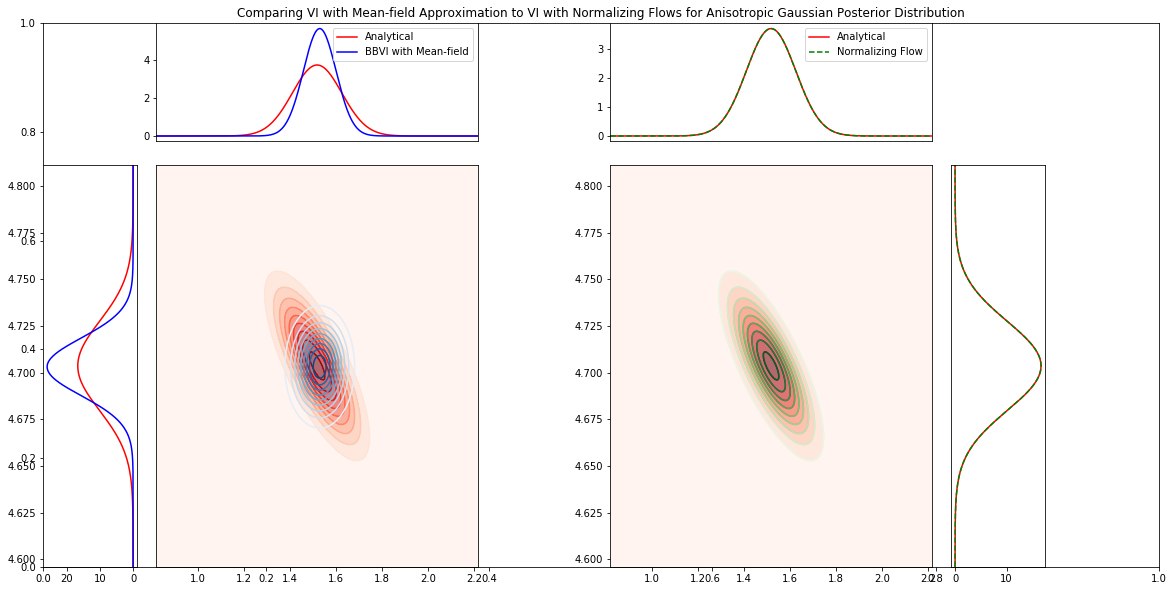

In [0]:
# Plot both approximations overlaid on the posterior distribution for comparison
fig = plt.figure(figsize=(20,10))
plt.title("Comparing VI with Mean-field Approximation to VI with Normalizing Flows for Anisotropic Gaussian Posterior Distribution")
gs = GridSpec(4,10)
ax_joint = fig.add_subplot(gs[1:4, 1:4])
ax_joint.set(xlim=w0_lims, ylim=w1_lims, yticks=[])
ax_joint.contour(x_grid, y_grid, z_p, levels=10, cmap='Reds')
ax_joint.contourf(x_grid, y_grid, z_p, levels=10, cmap='Reds', alpha=0.6)
ax_joint.contour(x_grid, y_grid, z_q, levels=10, cmap='Blues')

ax_marg_x = fig.add_subplot(gs[0, 1:4])
x_marginal = np.linspace(*w0_lims, 1000)
ax_marg_x.set(xlim=w0_lims, xticks=[])
ax_marg_x.plot(x_marginal, norm.pdf(x_marginal, mean[0], np.sqrt(cov[0][0])), color='r', label="Analytical")
ax_marg_x.plot(x_marginal, norm.pdf(x_marginal, variational_mean[0], np.sqrt(variational_cov[0])), color='b', label="BBVI with Mean-field")
ax_marg_x.legend(loc='upper right')

ax_marg_y = fig.add_subplot(gs[1:4, 0])
y_marginal = np.linspace(*w1_lims, 1000)
ax_marg_y.set(ylim=w1_lims)
ax_marg_y.invert_xaxis()
ax_marg_y.plot(norm.pdf(y_marginal, mean[1], np.sqrt(cov[1][1])), y_marginal, color='r')
ax_marg_y.plot(norm.pdf(y_marginal, variational_mean[1], np.sqrt(variational_cov[1])), y_marginal, color='b')

ax_nf = fig.add_subplot(gs[1:4, 5:8])
ax_nf.set(xlim=w0_lims, ylim=w1_lims)
ax_nf.contour(x_grid, y_grid, z_p, levels=10, cmap='Reds')
ax_nf.contourf(x_grid, y_grid, z_p, levels=10, cmap='Reds', alpha=0.6)
ax_nf.contour(x_grid, y_grid, z_nf, levels=10, cmap="Greens")

nax_marg_x = fig.add_subplot(gs[0, 5:8])
nx_marginal = np.linspace(*w0_lims, 1000)
nax_marg_x.set(xlim=w0_lims, xticks=[])
nax_marg_x.plot(x_marginal, norm.pdf(x_marginal, mean[0], np.sqrt(cov[0][0])), color='r', label="Analytical")
nax_marg_x.plot(x_marginal, norm.pdf(x_marginal, mean[0], np.sqrt(nf_cov[0][0])), color='g', linestyle='--', label="Normalizing Flow")
nax_marg_x.legend(loc='upper right')

nax_marg_y = fig.add_subplot(gs[1:4, 8])
ny_marginal = np.linspace(*w1_lims, 1000)
nax_marg_y.set(ylim=w1_lims, yticks=[])
nax_marg_y.plot(norm.pdf(y_marginal, mean[1], np.sqrt(cov[1][1])), y_marginal, color='r')
nax_marg_y.plot(norm.pdf(y_marginal, mean[1], np.sqrt(nf_cov[1][1])), y_marginal, color='g', linestyle='--')

plt.show()

Evidently, from our above plots, our VI using our fixed flows provides us with a much better approximation of our anisotropic Gaussian posterior in comparison to our black box VI approximation. A key reason for this is that the approach of using normalizing flows for VI is such that our posterior approximation is able to capture the inherent covariance in our data and is thus able to side-step some of the problematic implications of the mean-field assumption. 

We have, therefore, sufficiently shown that in at least some cases, VI with normalizing flows can outperform VI using the mean-field assumption.

That being said, our approach taken here is very much different from the one taken by Mohamed and Rezende. In their case, instead of using fixed planar flows, they employ a neural network to learn what the flows should be in order to approximate the posterior from the base distribution rather than manually deriving the flow analytically.

As such, we will now attempt a more complex implementation of normalizing flows using a neural network for VI.

---

# Questions to ask
- How best should we proceed with the complex implementation
- Should we include more analytical explanations behind why some of the features are as they are? If so, where?
  - Why we need invertible transformations
  - Why we cannot rely on analytically derived fixed flows
  - Why this approach might be more scalable

---

# Limitations of VI with Normalizing Flows
- Why do we need this instead of BBVI? In several contexts, the approach recommended by the authors do not outperform BBVI

- There's not that much evidence that it's strictly better as well; their approach has not been extensively tested beyond the examples in the paper (since its relatively new)

- The approach bypasses the mean-field asusmption but technically so does like 50 other approaches lmao. We cannot overstate this advantage



### LImitiations
- approach still based on some rules - what about the data would limit the use of NF.
- What limitations are there to the conclusions drawn.

---

# References
Blei, D.M., Kucukelbir, A., & McAuliffe, J.D. (2018). Variational Inference: A Review for Statisticians. 	arXiv:1601.00670.


Hoffman, M. D., Blei, D. M.,  Chong, W., and Paisley, J. (2013). Stochastic variational inference. Journal
of Machine Learning Research, 14:1303–1347.

Mohamed, S. and Rezende, J.  (2015). Variational Inference with Normalizing Flows. arXiv:1505.05770 [stat.ML] 

Wainwright, M. J. and Jordan, M. I. (2008). Graphical models, exponential families, and
variational inference. Foundations and Trends in Machine Learning, 1(1-2):1–305.






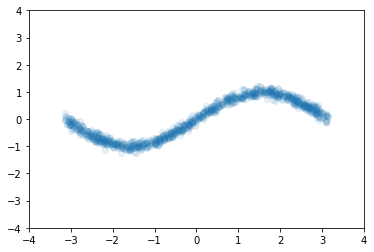

In [0]:
# Target density
n_samples = 1000
xs = 2*np.pi*np.random.random(n_samples) - np.pi
target_samples = np.sin(xs)+0.1*np.random.randn(n_samples)
fig, ax = plt.subplots()
ax.scatter(xs, target_samples, alpha=0.1)
ax.set(xlim=(-4,4), ylim=(-4,4))
plt.show()

In [0]:
def flow(z, lbda, func):
    func_eval = [lbda[:2]*func(np.dot(lbda[2:4], z[i])+lbda[-1]) for i in range(len(z))]
    return z + func_eval

def psi(z, lbda, func):
    func_eval = [func(np.dot(lbda[2:4], z[i])+lbda[-1])*lbda[2:4] for i in range(len(z))]
    return func_eval

In [0]:
def free_energy(z, lbda, q, p, flows, x):
    # z is samples of shape (S, K)
    # q is distribution z was drawn from
    # p is target distribution (observations?)
    # flows is list of flow functions
    q_exp = np.sum(q(z))/len(z)
    joint_exp = sum(q(z[-1])+p(x))/len(z)
    flow_exp = 0
    for k in range(len(z)):
        psi_vals = flows[k](z[k], lbda[k])
        psi_vals = [psi_vals[i] * lbda[k][2:4] for i in range(len(psi_vals))]
        psi_vals = [np.log(np.abs(1 + np.dot(psi_vals[i], lbda[k][:2].T))) for i in range(len(psi_vals))]
        flow_exp += sum(psi_vals)

    return q_exp + flow_exp + joint_exp

In [0]:
x_grid, y_grid = numpy.mgrid[-3:3:.01, -3:3:.01]
pos = numpy.dstack((x_grid, y_grid))

samples = np.random.multivariate_normal([0,0], np.eye(2), 100)

#fig, ax = plt.subplots(figsize=(12,12))

# Setting up flow parameters, commented out subsequent flow steps
us = [np.array([3,0])]       #, np.array([0.5, 0.5]), np.array([-1, 1]), np.array([1, -1])]
bs = [0]                     #, 1, 2, 3]
ws = [np.array([15, 0])]     #, np.array([1,0]), np.array([0,1]), np.array([1,1])]
lbda = np.array([3, 0, 15, 0, 0])
func = lambda x: np.tanh(x)
flow_func = lambda z, lbda: psi(z, lbda, grad(func))

#TODO: Need function to minimize and params (Free Energy)
p = lambda x: np.log(norm.pdf(x[1] - np.sin(x[0]), 0, 0.1))
q = lambda z: np.log(multivariate_normal.pdf(z, [0,0], np.eye(2)))

en = free_energy(samples[np.newaxis,], lbda[np.newaxis,], q, p, [flow_func], target_samples)
print(en)


-1550.7428557910407
